In [ ]:
# cell for importing packages for the first time
# import Pkg; Pkg.add("StaticArrays")
# import Pkg; Pkg.add("Revise")


# import Pkg; Pkg.add("@time")
Pkg.add("FastGaussQuadrature")

In [ ]:
ENV["PYTHON"]=""
import Pkg;
Pkg.add("PyCall")

In [ ]:
Pkg.add("PyPlot")

In [141]:
using Plots

using StaticArrays
import LinearAlgebra
import FastGaussQuadrature

push!(LOAD_PATH, pwd())

module PhysConst
    export CL,Gr,QE,MSOL,MSUN,ARAD,SGMB,RGAS,
            PC,RSUN,RSUN,YR,MSOLYR,GAM53,KPE,PARSEC,KPE,KPD,M_MW
    CL = 2.997925E10;
    Gr = 6.67384E-8; 
    QE=4.80325E-10;
    MSOL = 1.989E33;
    MSUN = 1.989E33;

    ARAD = 7.56464E-15; 
    SGMB = ARAD*CL/4
    
    KBLZ = 1.3807E-16 

    HPL = 6.6261E-27 
    HPLB= 1.0546E-27

    RGAS = 8.31E7; 
    PC = 3.085678E18;
    MP = 1.672661E-24; 
    M_U = 1.660531E-24
    RSOL = 6.95E10
    RSUN = 6.95E10
    YR = 365*24*3600.
    MSOLYR = 1.989e33/YR

    GAM = 5/3.

    KPE = 0.4
    PARSEC=3.0E18
    KPD = 10.

    M_MW=1.

    tst=1

end


#-------------------------------------- STEP 1 -------------------------------------- #
# define necessary data structures

# module SpaceRadGrid

        
# gaussnodes -   Gauss-Legendre nodes
# gaussweights - Gauss-Legendre weights



using StaticArrays
import Base.@kwdef

    const IX = 1
    const IY = 2
    const IZ = 3

    @show const BIGNUMBER = 1.0E50



    @kwdef struct SGridPar
        

        Nactive = 30;
    
        nghost = 1 #N of ghost cells at every boundary.
            
        Nx = Nactive;   # N of active cells
        Ny = Nactive;
        Nz = Nactive;
        
        Nxtot = Nx +  2*nghost;
        Nytot = Ny +  2*nghost;
        Nztot = Nz +  2*nghost;
    
        is = 1 + nghost; 
        ie = Nxtot -nghost;        

        js = 1 + nghost;  
        je = Nytot - nghost;
        
        ks = 1 + nghost;
        ke = Nztot - nghost;
            
        x1s = -1.
        x1e = 1.
    
        x2s = -2.
        x2e = 2.

        x3s = -3.
        x3e = 3.
        
    end

    @kwdef struct RGridPar
    
        Nfreq = 10 ; # ν - N bins 
        NumPhi = 5
        NumTheta = 5
    
        Nang = NumPhi*NumTheta    
        N_fre_ang = Nfreq*Nang  
            
    
    end




# ------ Init Space and Radiation grids --------------------------------

sg= SGridPar()
rad = RGridPar()


# radiaion matter grid is offset from the space grid boundaries
roffst = 2

is_r = sg.is + roffst
ie_r = sg.ie - roffst 

js_r = sg.js + roffst
je_r = sg.je - roffst 

ks_r = sg.ks + roffst
ke_r = sg.ke - roffst 


# μ = zeros(Float64, rad.NumTheta)     
# @show gaussnodes, gaussweights = FastGaussQuadrature.gausslegendre(rad.NumTheta);
# @show μ .= gaussnodes

θ = range(0, pi; length = rad.NumTheta)
ϕ   = range(0, 2pi-pi/rad.NumPhi; length = rad.NumPhi)


# ----------------------------------------------------------------------

#                                Grid

x1 = Array{Float64}(undef, sg.Nxtot)
x2 = Array{Float64}(undef, sg.Nytot)
x3 = Array{Float64}(undef, sg.Nztot)

x1b = Array{Float64}(undef, sg.Nxtot)
x2b = Array{Float64}(undef, sg.Nytot)
x3b = Array{Float64}(undef, sg.Nztot)

#                               Gas   

const Tsc=1.0E7

den = zeros(Float64, sg.Nxtot,sg.Nytot,sg.Nztot) 
Tgas = zeros(Float64, sg.Nxtot,sg.Nytot,sg.Nztot) 
OpaCon = zeros(Float64, sg.Nxtot,sg.Nytot,sg.Nztot)


@show νRange = zeros(Float64, rad.Nfreq) .= range(1.0E17, 1.0E17, length=rad.Nfreq)

IrPos = zeros(Float64, rad.N_fre_ang, sg.Nxtot, sg.Nytot, sg.Nztot); # radiation intensity, forward
IrNeg = zeros(Float64, rad.N_fre_ang, sg.Nxtot, sg.Nytot, sg.Nztot); # radiation intensity, backward




function MakeXYZstagGrid(x1, x2, x3, x1b, x2b, x3b, sg)  #staggered grid

    # add check sizes
    
    xtmp = range(sg.x1s, sg.x1e; length = sg.Nxtot - 2sg.nghost)
    
#     @show sg.is, sg.ie sg.Nx sg.nghost size(xtmp) size(x1) size(sg.is:sg.ie) size(2:2)
    
    x1[sg.is:sg.ie] .= xtmp[:] 
    x1[sg.is-1] = 2*x1[sg.is]- x1[sg.is+1]
    x1[sg.ie+1] = 2*x1[sg.ie] -x1[sg.ie-1]

    xtmp = range(sg.x2s, sg.x2e; length = sg.Nytot - 2sg.nghost)    

    x2[sg.js:sg.je] .= xtmp[:]     
    x2[sg.js-1] = 2*x2[sg.js]- x2[sg.js+1]
    x2[sg.je+1] = 2*x2[sg.je] -x2[sg.je-1]

    xtmp = range(sg.x3s, sg.x3e; length = sg.Nztot - 2sg.nghost)    

    x3[sg.ks:sg.ke] .= xtmp[:]     
    x3[sg.ks-1] = 2*x3[sg.ks]- x3[sg.ks+1]
    x3[sg.ke+1] = 2*x3[sg.ke] -x3[sg.ke-1]
    
    
    x1b[1] = x1[1] - 0.5(x1[sg.is]-x1[1])    
    for i in sg.is:(sg.ie+1)
        x1b[i] = x1[i-1] + 0.5(x1[i]-x1[i-1])
    end

    x2b[1] = x2[1] - 0.5(x2[sg.js]-x2[1])    
    for j in sg.js:(sg.je+1)
        x2b[j] = x2[j-1] + 0.5(x2[j]-x2[j-1])
    end

    x3b[1] = x3[1] - 0.5(x3[sg.ks]-x3[1])    
    for k in sg.ks:(sg.ke+1)
        x3b[k] = x3[k-1] + 0.5(x3[k]-x3[k-1])
    end
    
    
    
end

mutable struct LongRay
    numOfElm::Int32    
    id::Int32 #id in dir array
    ijkOfCellCrossed :: Matrix{Int32}        
    xyzPos :: Matrix{Float64}
    orig::Int32 #the origin of the ray, as lin index
end


mutable struct LongRay1  #long ray without a dir

    numOfElm::Int32    
    
#     hed :: Vector{Int32}    
#     dir :: Vector{Float64} 
    
    ijkOfCellCrossed :: Matrix{Int32}        
    xyzPos :: Matrix{Float64}
end


mutable struct RayPair
    
    hed ::Vector{Int32}    
    
    dir::Vector{Float64}    
    
    ray_f:: LongRay1 #forward    
    ray_b:: LongRay1 #backward    
    
end



MakeXYZstagGrid(x1,x2,x3,x1b,x2b,x3b,sg)
@show x3
@show x3b

    
NumElemInRayMax = 2*max(sg.Nxtot,sg.Nytot,sg.Nztot)
    
arrOfLongRay = Array{LongRay, 4}(undef, (rad.Nang, sg.Nxtot, sg.Nytot, sg.Nztot)); 
    
# @time rayPairArr = Array{RayPair, 4}(undef, (rad.Nang, sg.Nxtot, sg.Nytot, sg.Nztot)); 
     


function xyzToijk(xin::Float64, yin::Float64, zin::Float64)
    i = argmin( abs.(x1 .-xin )); 
    j = argmin(abs.(x2.-yin)); 
    k = argmin(abs.(x3.-zin))    
    return(i,j,k)
end

# argmin(νRange,1.0E14)


const BIGNUMBER = 1.0e50 = 1.0e50
νRange = (zeros(Float64, rad.Nfreq) .= range(1.0e17, 1.0e17, length = rad.Nfreq)) = [1.0e17, 1.0e17, 1.0e17, 1.0e17, 1.0e17, 1.0e17, 1.0e17, 1.0e17, 1.0e17, 1.0e17]


x3 = [-3.206896551724138, -3.0, -2.793103448275862, -2.586206896551724, -2.3793103448275863, -2.1724137931034484, -1.9655172413793103, -1.7586206896551724, -1.5517241379310345, -1.3448275862068966, -1.1379310344827587, -0.9310344827586207, -0.7241379310344828, -0.5172413793103449, -0.3103448275862069, -0.10344827586206896, 0.10344827586206896, 0.3103448275862069, 0.5172413793103449, 0.7241379310344828, 0.9310344827586207, 1.1379310344827587, 1.3448275862068966, 1.5517241379310345, 1.7586206896551724, 1.9655172413793103, 2.1724137931034484, 2.3793103448275863, 2.586206896551724, 2.793103448275862, 3.0, 3.206896551724138]
x3b = [-3.310344827586207, -3.103448275862069, -2.896551724137931, -2.689655172413793, -2.4827586206896552, -2.2758620689655173, -2.0689655172413794, -1.8620689655172413, -1.6551724137931034, -1.4482758620689655, -1.2413793103448276, -1.0344827586206897, -0.8275862068965517, -0.6206896551724138, -0.4137931034482759, -0.20689655172413793, 0.0, 0.20689655172413796, 0.4137

xyzToijk (generic function with 1 method)

In [142]:
# import PhysConst, only:HPL


function DefinePhysModel(sg::SGridPar, rad::RGridPar)
    Tgas .= Tsc
    
    den .=  1.0/PhysConst.MP
    
    den .= 1.0E18
    
end



function Bν(ν::Float64,T::Float64)
    
  return ( 2.0*PhysConst.HPL* ν^3/(PhysConst.CL^2)/
        (exp(PhysConst.HPL*ν/PhysConst.KBLZ/T)-1.) )
    
end


function testBν()
    
    Trange = range(10.0^4, 10.0^5, length= 3)
    
    T=Tsc
    y =[Bν(nu,T) for nu in νRange]

#     @show -Bν(ν, T)
    
    plot(νRange, y, xaxis=:log, yaxis=:log)

#     for T in Trange
#     #     @show T
#         y =[Bν(nu,T) for nu in νRange]

#         plot!(νRange, y, xaxis=:log, yaxis=:log)


#     end

#     current()

end

DefinePhysModel(sg, rad);

@show Bν(1.0E17, 10.0E5)



Bν(1.0e17, 1.0e6) = 122.46767750163146


122.46767750163146

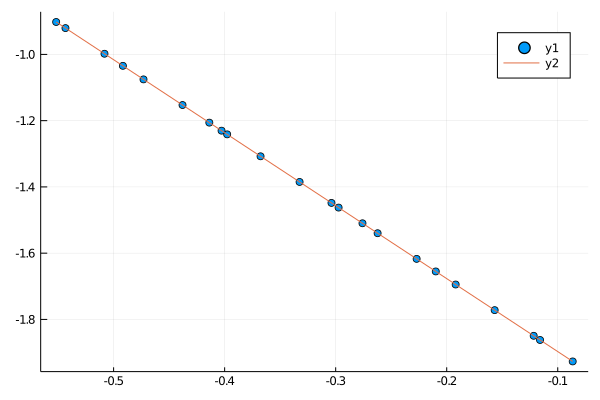

dir = norm[rayid, :] = [-0.6300367553350504, -0.32101976096010315, 0.7071067811865476]
ip = ijk_pos_s[IX] = 16
ray.xyzPos[ax2, :] = [-0.0865353603273941, -0.11593005169719448, -0.12167504649942369, -0.1568147326714533, -0.19195441884348285, -0.20985912060882486, -0.22709410501551247, -0.26223379118754203, -0.27586206896551724, -0.29737347735957165, -0.30378818952045533, -0.3325131635316012, -0.36765284970363077, -0.3977172584320857, -0.4027925358756604, -0.4137931034482759, -0.43793222204768995, -0.47307190821971956, -0.49164632734371605, -0.5082115943917491, -0.5433512805637787, -0.5517241379310345, 2.364235521e-314, 2.364235584e-314, 2.3642356475e-314, 2.36307004e-314, 2.364235695e-314, 2.3630700794e-314, 2.364235774e-314, 2.3642358214e-314, 2.3642359004e-314, 2.364235932e-314, 2.363070111e-314, 2.364236011e-314, 2.36423609e-314, 2.364236169e-314, 2.3642362325e-314, 2.3630701743e-314, 2.36423628e-314, 2.363070214e-314, 2.364236343e-314, 2.3642363906e-314, 2.364236438e-314, 2.36307024

In [143]:
# module RadiationTransfer

x3c = Array{Float64}(undef, 3);
xn = Array{Float64}(undef, 3)
distToNextCell = fill(BIGNUMBER,3) #used in FirstTimeTraceGridOverOneLongRay()
ijk_pos_s = Array{Int32,1}(undef,3)
ijk_pos = Array{Int64}(undef,3)
ijk_max = Array{Int64}(undef,3)
ijk_min = Array{Int64}(undef,3)
ijk_tmp = Array{Int64}(undef,3)

ijk_max .= [ sg.ie+1, sg.je+1, sg.ke+1 ] #max ijk index 
ijk_min .= [ sg.is, sg.js, sg.ks ] #min index
ijk_tmp .= [0, 0, 0]

xbi_zip= [x1b, x2b, x3b]

# display(xbi_zip)

function FirstTimeTraceGridOverOneLongRay(dir::Vector{Float64}, rayOne::LongRay, sg::SGridPar)

    
    dist = 0.0   
    distToNextCell .= BIGNUMBER
    rayOne.numOfElm = 0.0
    
    xn .= x3c
    
#     println("start: ", xn ,"\n")
        
    itermax = 2 * sg.Nx

    for iter in 1:itermax #max length, may be smaller than actual

#      println("*************************")
#      @show xn iter
#      @show ijk_pos

        for (n_it, norm_i ) in enumerate(dir) #QUESTION: maybe iter over pre-calclulated 1/norms

            xc = x3c[n_it] 

             if iter > 1 

                ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, dir[n_it])

                itmp = ijk_tmp[n_it]
             
                xn[n_it] = xbi_zip[n_it][itmp]                                            


             elseif iter==1 #first step from the middle of the cell

                if norm_i>0                
                   
                    itmp = ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, dir[n_it])
                    
                elseif norm_i <0               
                    
                    itmp = ijk_tmp[n_it] = ijk_pos[n_it]  #belongs to the same index                                
                else
                    
                    itmp = ijk_pos[n_it]            
                    
                end

                xn[n_it] = xbi_zip[n_it][itmp]

             end
                # @show itmp

             if norm_i != 0                      
                               
                distToNextCell[n_it] = abs((xn[n_it] - xc)/dir[n_it])

             else
                distToNextCell[n_it] = BIGNUMBER
             end


#         println("iter= ",iter," xn=",  xn, " ===> ", "n_it = ",n_it," \n ",
#                 "distToNextCell[",n_it,"]=",distToNextCell[n_it])

            end #for loop over possible directions
                                
        posIndxToUpdate = argmin( distToNextCell )

        dist = distToNextCell[posIndxToUpdate]


        ijk_pos[posIndxToUpdate] = ijk_tmp[posIndxToUpdate] #update only relevant one
    

        xn .= x3c .+ dir*dist   
        
#         xn[posIndxToUpdate] = xbi_zip[posIndxToUpdate][ijk_tmp[posIndxToUpdate]]        
#         println(posIndxToUpdate, "   Corrected: ", xn) 
#         @show dir
#         @show posIndxToUpdate ijk_pos ijk_tmp                
#         println("xprev = ", x3c,   " ", "xaft= ", xn, "\n")
        
#         @show posIndxToUpdate dist

        
        x3c .= xn
        
        if ijk_pos[posIndxToUpdate] == ijk_max[posIndxToUpdate] || 
            
            ijk_pos[posIndxToUpdate] == ijk_min[posIndxToUpdate] || 

            ijk_pos[posIndxToUpdate] == 1 ||             
            
            xn[1] <= x1b[sg.is] || xn[1] >= x1b[sg.ie] ||
            xn[2] <= x2b[sg.js] || xn[2] >= x2b[sg.je] ||
            xn[3] <= x3b[sg.ks] || xn[3] >= x3b[sg.ke] ||                        
            iter > 100 
                        
#             @show ijk_pos
#             println("quit..")
            break; 
        end      

        #update rayOne
        rayOne.numOfElm = iter
        rayOne.ijkOfCellCrossed[:,iter] .= ijk_pos
        rayOne.xyzPos[:,iter] .= xn

        if iter>1 && LinearAlgebra.norm(rayOne.xyzPos[:,iter]-rayOne.xyzPos[:,iter-1])<1E-10
            @show iter, rayOne.ijkOfCellCrossed[:,iter], rayOne.ijkOfCellCrossed[:,iter-1]
            @show dir            
            println( "!!!!!!!!!!!!  distance is very small  !!!!!!! \n")
        error( "error! ")            
        end                                
#         println("iter=", iter,"  ", "xn= ", xn)


    end #over ray

end # FirstTimeTraceGridCalcOneLongRay



function InitRayDirections(rad::RGridPar, sg::SGridPar)
            
    norm = zeros(Float64, rad.Nang, 3);
    
    m=1
    for (i,ph_i) in enumerate(ϕ)
        for (j,th_j) in enumerate(θ)
            
            μj = cos.(th_j)
            sinth_j = sqrt(1-μj^2)
            
            norm[m, IX] = sinth_j *sin(ph_i)
            norm[m, IY] = sinth_j *cos(ph_i)                 
            norm[m, IZ] = μj
                        
        m+=1;            
        end
    end

    return(norm)
end

norm = InitRayDirections(rad,sg)

# *****************************************************************
function PlotRay(ray::LongRay, ax1, ax2)

    
#     @show r0 = [x1[ic],x2[jc],x3[kc]]
#     m = 1
#     @show dir = norm[m,:]
#     ray = arrOfLongRay[m,ic,jc,kc]
#     for i in 1:ray.numOfElm
#         r = ray.xyzPos[:,i]
#     end

    @show y1 = ray.xyzPos[ax2,1:ray.numOfElm]
    @show x1 = ray.xyzPos[ax1,1:ray.numOfElm]
    
    p1 = plot(x1, y1,  seriestype = :scatter)
    p2 = plot!(p1, x1, y1)
        
    display(p2)

    
end 

function testFirstTimeTraceGridOverOneLongRay(rad::RGridPar, sg::SGridPar, swch)
    rayid = rand(1:rad.Nang)
    

    @show dir = norm[rayid,:]
    posInRay = 1 #
    
    if swch=="LongRay"
        testRay = LongRay(NumElemInRayMax, rayid,          
            Array{Int32}(undef,3,NumElemInRayMax),
            Array{Float64}(undef,3,NumElemInRayMax), posInRay )       
    else
        error("swch is not supported")
    end

    
    numTests=1
    for n = 1:numTests
        println( " test :", n )
        
        ijk_pos_s[:] = [argmin(abs.(x1.-0.)), argmin(abs.(x2.-0.)), argmin(abs.(x3.-0.))]; 

        ijk_pos_s[:] = [rand( is_r:ie_r),  rand(js_r:je_r),  rand(ks_r:ke_r) ]    
        
        ijk_pos .= ijk_pos_s

        ip=ijk_pos_s[IX]; jp=ijk_pos_s[IY]; kp=ijk_pos_s[IZ]                
     
        x3c .= [ x1[ip], x2[jp], x3[kp] ]
        
        xyz_s = [ x1[ip], x2[jp], x3[kp] ]


        FirstTimeTraceGridOverOneLongRay(dir, testRay, sg)     
        
      
        
        rprev= zeros(Float64,3)
        
#         @show testRay.numOfElm
        
        if testRay.numOfElm > 0
            rprev = xyz_s
            for i=1:testRay.numOfElm
                  
                ds=LinearAlgebra.norm(testRay.xyzPos[:,i] .- rprev)

                rprev .= testRay.xyzPos[:,i]
                
#                 @show i,ds
            end
            
                   
            xyz_e = testRay.xyzPos[:,testRay.numOfElm]                
            dist = LinearAlgebra.norm( xyz_e .- xyz_s)     


            xyz_0e = xyz_s + dir*dist

            Δ = LinearAlgebra.norm( xyz_e[:].-xyz_0e[:])/
                    LinearAlgebra.norm( xyz_0e[:])


            println("|| rend - rs ||/||rs|| = ",  Δ)    
            if Δ <= 1e-5
                println(" Test Passed ! ")    
            else
                println("𝐧 = ",  dir)                
                println(" xyz_e= ",  xyz_e)                
                println(" xyz_s= ",  xyz_s)                
                println(" xyz_0e= ",  xyz_0e)                    
                println(" dist=", dist)      
                error("Test Failed !")
            end

            
        end
            

        
    end
end

function test2(rad, sg)
    rayid = 2
    rayid = rand(1:rad.Nang)
    posInRay = 1 #
    x0=0. 
    y0=0. 
    z0=-2.
    
    @show dir = norm[rayid,:]

    ax1= 1
    ax2 = 2
    ax3 = 3
    
        
    ray = LongRay(NumElemInRayMax, rayid,          
            Array{Int32}(undef,3,NumElemInRayMax), Array{Float64}(undef,3,NumElemInRayMax),posInRay )       

    
    ic,jc,kc=xyzToijk(x0, y0, z0)                    
    ijk_pos .= ijk_pos_s.=[ic,jc,kc]

    
    @show  ip=ijk_pos_s[IX]; jp=ijk_pos_s[IY]; kp=ijk_pos_s[IZ]                
     
    
    
    x3c .= [ x1[ip], x2[jp], x3[kp] ]
        
        
    xyz_s = [ x1[ip], x2[jp], x3[kp] ]

    FirstTimeTraceGridOverOneLongRay(dir, ray, sg)     

    
    @show ray.xyzPos[ax2,:] ray.numOfElm
  
    PlotRay(ray, ax2, ax3)
    
end



# testFirstTimeTraceGridOverOneLongRay(rad, sg, "LongRay")

test2(rad, sg)


1st time trace grid with long rays, perfom allcoations etc ..
 ************************************ 


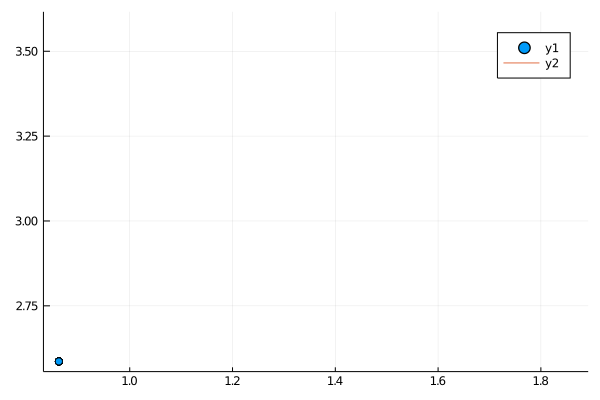

is = is_r = 4
ie = ie_r = 29
ray = arrOfLongRay[rand(1:rad.Nang), rand(is_r:ie_r), rand(js_r:je_r), rand(ks_r:ke_r)] = LongRay(41, 19, Int32[30 29 29 28 28 27 26 26 25 25 24 23 23 22 21 21 20 20 19 19 18 17 16 16 15 14 14 13 13 12 11 11 10 10 9 8 8 7 6 6 5; 20 20 19 19 19 19 19 19 19 18 18 18 18 18 18 17 17 17 17 17 17 17 17 17 17 17 16 16 16 16 16 16 16 15 15 15 15 15 15 14 14; 11 11 11 11 10 10 10 9 9 9 9 9 8 8 8 8 8 7 7 7 7 7 7 6 6 6 6 6 5 5 5 4 4 4 4 4 3 3 3 3 3], [0.896551724137931 0.8491760363810862 0.8275862068965517 0.8176254140674388 0.7586206896551724 0.6896551724137931 0.6332792366491559 0.6206896551724137 0.578471139070031 0.5517241379310345 0.4827586206896552 0.4489330592308729 0.41379310344827586 0.3448275862068966 0.3077662417589758 0.27586206896551724 0.2645868818125897 0.20689655172413796 0.1724137931034483 0.13793103448275862 0.06896551724137931 0.0 -0.06896551724137931 -0.10410547302397596 -0.13793103448275862 -0.20689655172413796 -0.23364355286313437 -0.275862068965

In [144]:


# **************** Trace grid with long rays  ****************** #
    
println("1st time trace grid with long rays, perfom allcoations etc ..")

function TraceGridAllocRayArr(rad::RGridPar, sg::SGridPar, swch)
    
    dirOld =Array{Float64}(undef,3)
    dirf =Array{Float64}(undef,3)
    dirb =Array{Float64}(undef,3)

    x3c_head=Array{Float64}(undef,3)
    ijk_pos_head =Array{Int32}(undef,3)
    
    Nr=NumElemInRayMax
    posInRay =1 
    
    testRay_f = LongRay(Nr,1, Array{Int32}(undef,3,Nr),Array{Float64}(undef,3,Nr),posInRay)       
    testRay_b = LongRay(Nr,1, Array{Int32}(undef,3,Nr),Array{Float64}(undef,3,Nr),posInRay)       

    
    
    if swch=="All"
        is = is_r; ie = ie_r
        js = js_r; je = je_r 
        ks = ks_r; ke = ke_r         
    elseif swch=="OneCell"
        is=ie=ijk_pos_s[IX]; js=je=ijk_pos_s[IY]; ks=ke=ijk_pos_s[IZ]
    else 
        error("Unknown case in TraceGridAllocRayArr")        
    end
         


    for k=ks:ke
    
        for j=js:je        

            for i=is:ie    
        


                if swch=="All"
                    ijk_pos_s.= [i,j,k]   
                end   
                
                ijk_pos_head .= ijk_pos_s #remember the origin
                
                for m=1:rad.Nang #, ipos=1:sg.Nxtot, jpos=1:sg.Nytot, kpos=1:sg.Nztot

#      @show m " new angle  ****************"
                    dirf .= norm[m,:]
                    dirb .= -norm[m,:]

                    ip=ijk_pos_s[IX]; jp=ijk_pos_s[IY]; kp=ijk_pos_s[IZ]
           
                    ijk_pos .= ijk_pos_s        
                    x3c .= [ x1[ip], x2[jp], x3[kp] ]
                    
                    x3c_head .= x3c #origin 
                    
# @show "forw"
                    FirstTimeTraceGridOverOneLongRay(dirf, testRay_f, sg)        
                    
                    

                   ijk_pos .= ijk_pos_s           
                    x3c .= [ x1[ip], x2[jp], x3[kp] ]
# @show "back"
                    FirstTimeTraceGridOverOneLongRay(dirb, testRay_b, sg)                                            
        
               

#              @show  ijk_pos dirf
                    
                    # now, when the length of the ray is known, allocate arrOfLongRay[m,i,j,k]

                    Ntot = testRay_f.numOfElm + testRay_b.numOfElm +1
                    
                    origCellId = testRay_b.numOfElm + 1 #knowing origCellId one can calc the origin cell
                    
                    arrOfLongRay[m,ip,jp,kp] = LongRay(Ntot, m,            
                        Array{Int32}(undef,3,Ntot), Array{Float64}(undef,3,Ntot), origCellId)

                    arrOfLongRay[m,ip,jp,kp].id = m


                    for iter = 1:testRay_b.numOfElm
                        ib = testRay_b.numOfElm - iter+1                         
                        arrOfLongRay[m,ip,jp,kp].ijkOfCellCrossed[:,iter] = testRay_b.ijkOfCellCrossed[:,ib]                                    
                        arrOfLongRay[m,ip,jp,kp].xyzPos[:,iter] = testRay_b.xyzPos[:,ib]                                    
                   end                       

                   arrOfLongRay[m,ip,jp,kp].ijkOfCellCrossed[:,origCellId] .= ijk_pos_head
                   arrOfLongRay[m,ip,jp,kp].xyzPos[:,origCellId] .= x3c_head
                    
                    for iter = testRay_b.numOfElm + 2 : Ntot

                        i = iter - testRay_b.numOfElm -1 # 1, 2,3, ... (testRay_f.numOfElm + testRay_b.numOfElm)

                        arrOfLongRay[m,ip,jp,kp].ijkOfCellCrossed[:,iter] = testRay_f.ijkOfCellCrossed[:,i]

                        arrOfLongRay[m,ip,jp,kp].xyzPos[:,iter] = testRay_f.xyzPos[:,i]

                    end


              
                end 
            end
        end
    end
   
    
end

# function distAlongRay
#         if testRay.numOfElm > 0
#             rprev = xyz_s
#             for i=1:testRay.numOfElm
#                   ds=LinearAlgebra.norm(testRay.xyzPos[:,i] .- rprev)

#                 rprev .= testRay.xyzPos[:,i]
                
# #                 @show i,ds
#             end
# end

function testTraceGridAllocRayArr(rad, sg)            

    
#     ijk_pos_s[:] = [rand(sg.is:sg.ie),  rand(sg.js:sg.je),  rand(sg.ks:sg.ke) ]    
#     ijk_pos .= ijk_pos_s             
#    @show  ijk_pos_s

    
#      TraceGridAllocRayArr(rad, sg, "OneCell") #"OneCell"        
#      @show ray =  arrOfLongRay[rand(1:rad.Nang), ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]             
     println(" ************************************ ")     
    
      TraceGridAllocRayArr(rad, sg, "All")
    
      @show is = is_r; 
      @show ie = ie_r
      js = js_r; je = je_r 
      ks = ks_r; ke = ke_r  
    
    @show ray =  arrOfLongRay[rand(1:rad.Nang),rand(is_r:ie_r),  rand(js_r:je_r),  rand(ks_r:ke_r) ] 


    println(" ************************************ ")     
    
    
#      PlotRay(ray, ax1, ax2)

end







testTraceGridAllocRayArr(rad, sg)        



function test3()
    rayid = rand(1:rad.Nang)

    x0=0. 
    y0=0. 
    z0=0.
      
    ax1= 1
    ax2 = 2
    ax3 = 3
    
    @show dir = norm[rayid,:]
    
    ic,jc,kc = xyzToijk(x0, y0, z0)                    


    ray =  arrOfLongRay[rayid, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]
    
    
    @show ray.xyzPos[3,:]
    
    PlotRay(ray, ax1, ax3)
    
end
test3()

# **************************************************************#    

<h1>
<b>
Numerical
</b>
</h1>

$$   
 \begin{equation}    
    p\frac{d^2u}{dt^2} = u - S\mbox{,}
 \end{equation}
$$  


<b> Matrix  </b> eq: 
$$
-A_i u_{i-1} + B_i u_{i} -C_i u_{i+1} = S_i
$$

Coefficients have a slightly different form compared to <b>RH91</b> for a slightly better representation of 
the numerical derivative on a staggered grid. The source term allows for implicit contribution from the $b_m u_m$ from $S$. 
 
 $$
 y_i \left(-b_m
    +\frac{p}{\delta \tau _i}
    \left(\frac{1}{\delta \tau _{i+\frac{1}{2}}}+\frac{1}{\delta \tau
   _{i-\frac{1}{2}}}\right)
   +1\right)
   -\frac{p y_{i-1}}{\delta \tau _{i-\frac{1}{2}} \delta \tau _i}
   -\frac{p y_{i+1}}{\delta \tau _i \delta \tau _{i+\frac{1}{2}}}-S_i-S_\beta=0
 $$

Boundary conditions:
    
 $$
 \text{at}\quad t = \tau_1\simeq 0: \quad \alpha \, u'(t) + \beta \, u(t) = \gamma \mbox{,} 
 $$
 
 $$
 v(\tau=0)=u(\tau=0)\mbox{,}
 $$
    
 $$
 \text{at}\quad t = \tau_N: \quad \alpha_1 \, u'(t) + \beta_1 \, u(t) = \gamma_1 \mbox{.} 
 $$


 $$
    i=1:\qquad y_1 \left(-\frac{\alpha}{\delta \tau _{\frac{3}{2}}}+\beta\right)+\frac{\alpha}{\delta \tau _{\frac{3}{2}}} y_2=\gamma
 $$
 
 $$
 i=N:\qquad
  -\frac{\alpha_1 }{\delta \tau _{N-\frac{1}{2}} }y_{N-1} +y_N \left(\frac{\alpha_1}{\delta \tau _{N-\frac{1}{2}} }+\beta_1\right)=\gamma_1
$$
 
<h>
    <b> Source function: </b>   
</h>
$$ 
S_{i}=\alpha\,\Sigma_{n}^{N_{\nu}}a_{n}\phi_{in}\,\Sigma_{m=1}^{N_{m}}b_{m}u_{imn}
$$ 
    

<h1> Coeffs and Source Function </h1>

$$   
 \begin{equation}    
    p\frac{d^2u}{dt^2} = u - S\mbox{,}
 \end{equation}
$$  

$$
p=\frac{1}{(\chi_\nu + \sigma_\nu)^2}
$$

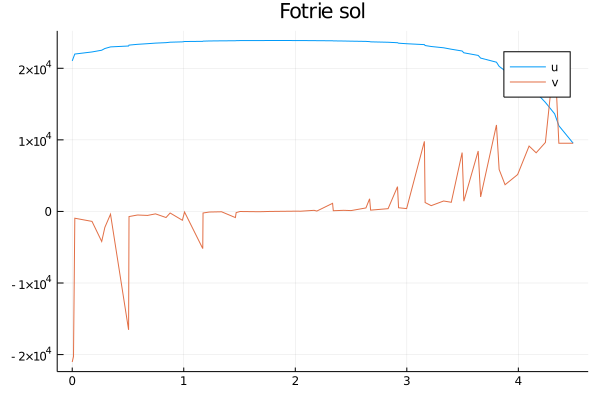

dir = norm[m, :] = [-0.41562693777745363, 0.5720614028176843, -0.7071067811865475]
ray.numOfElm = 62
s = [0.0, 0.01139258982482821, 0.02317562347549491, 0.17732388775794417, 0.2642879128265686, 0.29259590945650243, 0.3432551856910603, 0.5054002021776423, 0.5091864836241761, 0.5851918189130046, 0.6751177815572923, 0.7465124915287162, 0.8410490794904082, 0.8777877283695071, 0.98762478087979, 1.0069803774235242, 1.1703836378260097, 1.1729116753566402, 1.2287370702308638, 1.338842973289756, 1.4629795472825122, 1.4698493595819373, 1.5047742712228718, 1.6707055691559876, 1.7109616489330108, 1.7555754567390143, 1.8366368670891036, 1.9520739382840846, 2.0025681650222196, 2.0481713661955165, 2.1684994629553356, 2.193186227635158, 2.3344307608884516, 2.340767275652019, 2.4342985169862317, 2.500362058821567, 2.6333631851085215, 2.666293356754683, 2.6754108063373057, 2.832224654687799, 2.916523095688379, 2.9259590945650236, 2.9981559526209147, 3.1576353850394527, 3.1640872505540307, 3.218555004021

MethodError: MethodError: no method matching -(::Float64, ::Array{Float64,1})
Closest candidates are:
  -(::Float64, !Matched::Float64) at float.jl:403
  -(::Float64) at float.jl:393
  -(::Real, !Matched::Complex{Bool}) at complex.jl:304
  ...

In [154]:
function UpdateOpacGrid(sg::SGridPar)
     
    for k=1:sg.Nztot
        for j=1:sg.Nytot      
            for i=1:sg.Nxtot
                
            OpaCon[i,j,k]=2. 

            end
        end
    end  
            
end

function SrcFun(ν, i::Int32,j::Int32,k::Int32)

    T =  Tgas[i,j,k]
    
    Sf::Float64 = Bν(ν, T)
    
    return(Sf)
    
    
end

function ProgRayBC_1(ν, i::Int32,j::Int32,k::Int32)
    
        
    chi = OpaCon[i,j,k]     

    ν = 1.0E16    
    T=1.0E5


    alph = 1.0 
    

    bet = -chi            

    gam = 0.0 #Bν(ν, T)
        
    return(alph, bet, gam)
    
end
function ProgRayBC_N(ν, i::Int32,j::Int32,k::Int32)
    
    chi = OpaCon[i,j,k] 
    
    alphN = 1.    
    
    betN = chi

    gamN = 0.
    
    return(alphN,betN,gamN)
    
end

function ProgRay_pCoef(ν, i::Int32,j::Int32,k::Int32)
    chi = OpaCon[i,j,k]    
    p = 1/chi^2
 return(p)
end    

function ProgonRybHumAlongTheRay(ν, ray::LongRay, sg::SGridPar, rad::RGridPar)

    Nmat = ray.numOfElm
    
    u = zeros(Float64, Nmat)
    v = zeros(Float64, Nmat)
    
    
    A = zeros(Float64, Nmat)
    B = zeros(Float64, Nmat)    
    C = zeros(Float64, Nmat)
    D = zeros(Float64, Nmat)
    Z = zeros(Float64, Nmat)
    S = zeros(Float64, Nmat) #Rhs


    Sbet =0.
    bm = 0
    

    ic,jc,kc = ray.ijkOfCellCrossed[1,1],ray.ijkOfCellCrossed[2,1],ray.ijkOfCellCrossed[3,1]

    alph,bet,gam = ProgRayBC_1(ν, ic,jc,kc)
    
                       
    dx_i1 = LinearAlgebra.norm(ray.xyzPos[:,2].-ray.xyzPos[:,1])     
    dx_i=dx_i1 
    dx_ip05 = dx_i

    p = ProgRay_pCoef(ν, ic,jc,kc)
            
    A[1] = 0.
    
    B[1] = bet - alph/dx_ip05  
    
    C[1] = -alph/dx_ip05    
    
    S[1] = gam
    
    D[1] = C[1]/B[1]
    Z[1] = S[1]/B[1]
    
    C[Nmat]=0.
    
    for i = 2 : Nmat-1 #forward            
        ic,jc,kc = ray.ijkOfCellCrossed[1,i],ray.ijkOfCellCrossed[2,i],ray.ijkOfCellCrossed[3,i]
        
        dx_i = LinearAlgebra.norm(ray.xyzPos[:,i+1].-ray.xyzPos[:,i])

        if dx_i==0
            @show "warn: " Nmat, i, ic,jc,kc, ray.xyzPos[:,i+1],ray.xyzPos[:,i]
            error("dx=0 in ProgonRybHumAlongTheRay")
        end
            
        dx_im05 = dx_i         
        dx_ip05 = dx_i  

        p = ProgRay_pCoef(ν, ic,jc,kc)
        
        Sd = SrcFun(ν, ic,jc,kc)
        
        S[i] =Sd +Sbet
        
        A[i] = p /(dx_i*dx_im05)         
        B[i] = 1. - bm + ((1/dx_im05 + 1/dx_ip05)*p)/dx_i        
        C[i] = p/(dx_i*dx_ip05)  
                        
        k1 = 1/(B[i] - A[i]D[i-1])        
        D[i] = k1*C[i]        
        Z[i] = k1*( S[i]  + A[i]*Z[i-1])                     
    end 

    ic,jc,kc = ray.ijkOfCellCrossed[1,Nmat],ray.ijkOfCellCrossed[2,Nmat],ray.ijkOfCellCrossed[3,Nmat]    
    
    alphN,betN,gamN = ProgRayBC_N(ν, ic,jc,kc)

    dx_im05 = dx_i         
    dx_ip05 = dx_i 
    S[Nmat] = gamN
    
    C[Nmat]=0.
    D[Nmat]=0.

    A[Nmat] = (alphN/dx_im05)
    B[Nmat] = betN + alphN/dx_im05
    
    k1 = 1/(B[Nmat] - A[Nmat]*D[Nmat-1])
    
    Z[Nmat] = k1*( S[Nmat]  + A[Nmat]*Z[Nmat-1])                     

    u[Nmat] = Z[Nmat]
    v[Nmat] = u[Nmat]
    
    for i = Nmat-1:-1:1  #backsweep

        u[i] = D[i]*u[i+1]+Z[i]
        
        dx_i = LinearAlgebra.norm(ray.xyzPos[:,i+1].-ray.xyzPos[:,i])
        
         duds = (u[i+1]-u[i])/dx_i   
                
        ic,jc,kc = ray.ijkOfCellCrossed[1,i],ray.ijkOfCellCrossed[2,i],ray.ijkOfCellCrossed[3,i]
                
        chi = OpaCon[ic,jc,kc] 

        v[i] = -1.0/chi*duds
        
    end #for  
    #   calculate v at the origin     

#     i1 = ray.orig    
#     ic,jc,kc = ray.ijkOfCellCrossed[1,i1],ray.ijkOfCellCrossed[2,i1],ray.ijkOfCellCrossed[3,i1]
#     dx_i = LinearAlgebra.norm(ray.xyzPos[:,i1+1].-ray.xyzPos[:,i1])    
#     duds = (u[i1+1]-u[i1])/dx_i        
#     chi = OpaCon[ic,jc,kc]    
    
  
    
    return(u,v)
end #RTAlongTheRay

function ProgonRybHumAlongTheRayAppndxA(ν, ray::LongRay, sg::SGridPar, rad::RGridPar)
    
    Nmat = ray.numOfElm

    u = zeros(Float64, Nmat)
        
    D = zeros(Float64, Nmat)
    H = zeros(Float64, Nmat)
    F = zeros(Float64, Nmat)
    Z = zeros(Float64, Nmat)    


    
    Sbet =0.
    bm = 0.
    
    ic,jc,kc = ray.ijkOfCellCrossed[1,1],ray.ijkOfCellCrossed[2,1],ray.ijkOfCellCrossed[3,1]
    
    alph,bet,gam = ProgRayBC_1(ν, ic,jc,kc)
    
    dx_i1 = LinearAlgebra.norm(ray.xyzPos[:,2].-ray.xyzPos[:,1])     
    dx_i=dx_i1 
    dx_ip05 = dx_i
        
    p = ProgRay_pCoef(ν, ic,jc,kc)

    
    B1 = -bet + alph/dx_ip05
    C1 = alph/dx_ip05
    S1 = gam

    H[1] = B1-C1    
    F[1] = H[1]/C1
    Z[1] = S1/B1    
    
    
    for i = 2 : Nmat-1 #forward                        
        ic,jc,kc = ray.ijkOfCellCrossed[1,i],ray.ijkOfCellCrossed[2,i],ray.ijkOfCellCrossed[3,i]
        
        
        dx_i = LinearAlgebra.norm(ray.xyzPos[:,i+1].-ray.xyzPos[:,i])     
     
        if dx_i==0
            @show "warn: " Nmat, i, ic,jc,kc, ray.xyzPos[:,i+1],ray.xyzPos[:,i]    
            error("dx=0 in ProgonRybHumAlongTheRay")        
        end
       
        dx_im05 = dx_i         
        dx_ip05 = dx_i  

        p=ProgRay_pCoef(ν, ic,jc,kc)
        
        Sd = SrcFun(ν, ic,jc,kc)
        
        Si = Sd+Sbet
        
        Ai = p /(dx_i*dx_im05)         
        Bi = 1 - bm + ((1/dx_im05 + 1/dx_ip05)*p)/dx_i        
        Ci = p/(dx_i*dx_ip05)  
        H[i] = -Ai + Bi - Ci                
        F[i]=(H[i]+(Ai*F[i-1])/(1+F[i-1]))/Ci        
        Z[i]=(Si+Ai*Z[i-1])/(1+F[i])/Ci      
        
    end 


    ic,jc,kc = ray.ijkOfCellCrossed[1,Nmat],ray.ijkOfCellCrossed[2,Nmat],ray.ijkOfCellCrossed[3,Nmat]    
u
    alphN,betN,gamN = ProgRayBC_N(ν, ic,jc,kc)

    dx_im05 = dx_i         
    dx_ip05 = dx_i 
    SN = gamN
    
    CN=0.
#     @show 
    AN = (alphN/dx_im05)
#     @show 
    BN = betN + alphN/dx_im05
    
#     @show 
    Dnm1 = 1/(1.0+F[Nmat-1])    
    
    Z[Nmat] = (SN+AN*Z[Nmat-1])/( BN - AN*Dnm1)                         
    u[Nmat] = Z[Nmat]

    for i = Nmat-1:-1:1  #backsweep

        u[i] = u[i+1]/(1+F[i]) + Z[i]
        
    end #for                    
#     println("... ProgonRybHumAlongTheRayAppndxA done")
   
    i1=1
    ic,jc,kc = ray.ijkOfCellCrossed[1,i1],ray.ijkOfCellCrossed[2,i1],ray.ijkOfCellCrossed[3,i1]

    dx_i = LinearAlgebra.norm(ray.xyzPos[:,i1+1].-ray.xyzPos[:,i1])
    
    duds = (u[2]-u[1])/dx_i    
    
    chi = OpaCon[ic,jc,kc]    
    
    v = -1/chi*duds  
    
    return(u,v)
    
end #RTAlongTheRay


# tests
function TestRybHumAlongTheRay(rad)
    # pick a ray
    
    ijk_pos_s[:] = [rand(sg.is:sg.ie),  rand(sg.js:sg.je),  rand(sg.ks:sg.ke) ]    
    ijk_pos_s[:] = [rand( is_r:ie_r),  rand(js_r:je_r),  rand(ks_r:ke_r) ]    
    
#     ijk_pos_s[:] = [sg.is,  sg.je,  rand(sg.ks:sg.ke) ]    
    
    ijk_pos_s[:] = [is_r,  je_r,  rand(ks_r:ke_r) ]    
    
    NumTests=1
    
    Δ=0.
    

    for k=1:NumTests
        
        ijk_pos .= ijk_pos_s
        m = rand(1:rad.Nang)
        
#         m=1
         @show dir = norm[m,:]
        
        #need to first run=: TraceGridAllocRayArr(rad, sg)            
        ray =  arrOfLongRay[m, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]
        @show ray.numOfElm
        
        
#         if ray.numOfElm > 1        

        s = zeros(Float64,ray.numOfElm) #dist along the ray
        
        s[1]=0.

            for i = 2:ray.numOfElm
               s[i] =  s[i-1] + LinearAlgebra.norm(ray.xyzPos[:,i]-ray.xyzPos[:,i-1])      
            end
        
#     end
        @show s
        
        UpdateOpacGrid(sg)

        @show νi = νRange[6]
        
        u1,v1 = ProgonRybHumAlongTheRay(νi, ray, sg, rad)    
        
        u,v = ProgonRybHumAlongTheRayAppndxA(νi, ray, sg, rad);    
        
#         p1 = plot(s,u1)

        p2 = plot!( plot(s,u1,label = "u"), s,v1, title = "Fotrie sol", label = "v")
        
        display(p2)    
        

      @show length(u1)

        Δ += LinearAlgebra.norm((u-u1)./u1) + LinearAlgebra.norm((v-v1)./v1)
    println( "relative difference between ProgonRybHumAlongTheRayAppndxA 
        and ProgonRybHumAlongTheRay:\n Δu/u=", Δ )    

    if Δ <= 1e-2
        println(" Test Passed ! ")    
    else
        @show ijk_pos_s
        @show u 
        @show u1
        @show v1
        @show ray.ijkOfCellCrossed 
        @show ray.xyzPos
            
        plot(u)
            
#   error( " Test Failed !")
    end
        
    end



end







TestRybHumAlongTheRay(rad)



In [26]:

function RTSolveAllGrid(sg::SGridPar, rad::RGridPar)
       
   @show  is = is_r; ie = ie_r    
    js = js_r; je = je_r 
    ks = ks_r; ke = ke_r         

    UpdateOpacGrid(sg)
    
    
    
    for k=ks:ke
        for j=js:je        
            for i=is:ie   
                for m=1:rad.Nang
                    νi = νRange[6]
                    
  
                    ray =  arrOfLongRay[m,i,j,k]
                    
#                   @show ray.ijkOfCellCrossed[:,ray.orig] ray.ijkOfCellCrossed[:,ray.orig+1]
                    
                    u0, v1 = ProgonRybHumAlongTheRay(νi, ray, sg, rad);                    
                    
                    i1 = ray.orig
                    
                    u1 = u0[i1]

                    #display(plot(s,u1))
@show v1
                    
                    IrPos[m,i,j,k] = u1 + v1
                    IrNeg[m,i,j,k] = u1 - v1   
                    
#                     @show IrPos[m,i,j,k] IrNeg[m,i,j,k] 
                    
                end
    
    
            end
        end
    end
   
    println("RTSolveAllGrid done ..")
end


RTSolveAllGrid(sg,rad)


is = is_r = 4
v1 = -15382.270262269541
v1 = -7291.490176451239
v1 = -21161.23210436577
v1 = -6416.331001765747
v1 = 6004.742376100696
v1 = -15382.270262269541
v1 = -23052.556371451727
v1 = -29073.06907067338
v1 = -18738.477507116964
v1 = 6004.742376100696
v1 = -15382.270262269541
v1 = -999.1707623041592
v1 = -700.5927447072492
v1 = -358.11850236761603
v1 = 6004.742376100696
v1 = -15382.270262269541
v1 = 497.88794128428316
v1 = 9511.816242915465
v1 = 8178.194501166695
v1 = 6004.742376100696
v1 = -15382.270262269541
v1 = 791.8110995958482
v1 = -1683.0800420417795
v1 = 72.6050961422207
v1 = 6004.742376100696
v1 = -15382.270262269541
v1 = -7291.490176451239
v1 = -21161.23210436577
v1 = -6416.331001765747
v1 = 6004.742376100696
v1 = -15382.270262269541
v1 = -18076.345193622794
v1 = -24090.92257848652
v1 = -15339.616459077708
v1 = 6004.742376100696
v1 = -15382.270262269541
v1 = -999.1707623041476
v1 = 1787.494617892382
v1 = 453.74892152726227
v1 = 6004.742376100696
v1 = -15382.270262269541
v

Excessive output truncated after 524294 bytes.


v1 = -2669.0991960194956
v1 = -6169.470991434022
v1 = -13085.061678007192
v1 = -6378.336510346101
v1 = 889.2402090334142
v1 = -2669.0991960194956
v1 = -984.673470458307
v1 = -3769.981974596227
v1 = -1195.0295283488201
v1 = 889.2402090334142
v1 = 

In [ ]:
function AvrIntensAllGrid(rad::RGridPar)

    y=0.
    
    is = is_r; ie = ie_r    
    js = js_r; je = je_r 
    ks = ks_r; ke = ke_r         
  
    
    for k=ks:ke
        for j=js:je        
            for i=is:ie   
               
                y=0.
                
                for m=1:rad.Nang                               
                    y += (IrPos[m,i,j,k] + IrNeg[m,i,j,k])
                end
                y = y/rad.Nang
                
            end
        end
    end
    
     
    println( "AvrIntensAllGrid done .. ")
    
    return(y)
    
end

    
AvrIntensAllGrid(rad)



In [ ]:
using Plots
import GR

function PlotRad(x::Float64, y::Float64, z::Float64)
    @show ic,jc,kc = xyzToijk(x,y,z)
    
    y = IrPos[:,ic,jc,kc]
    
    @show size(y), size(μ) rad.Nang
    
    plot(1:rad.Nang, y)
    
end


PlotRad(0.,0.,0.)

In [ ]:
#  using PyPlot 
# using Plots
# gr() 


using Plots
import GR
gr()

function RTSolveTwoWayRay(RayIndex::Int64)        
   
   
    
    # pick a ray
    rayf =  rayPairArr[RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]].ray_f
    uf  = ProgonRybHumAlongTheRayAppndxA(rayf, sg, rad); #forward
    
    
#     @show RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]
    # @show rayPairArr[RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]].dir

  
    #     change direction                
     rayb =  rayPairArr[RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]].ray_b
     ub  = ProgonRybHumAlongTheRayAppndxA(rayb, sg, rad); #backward    
      
    utot = zeros(Float64,length(ub)+length(uf))    
#     utot[1:length(ub)] .= ub
#     plot(utot);    
    
    
    @show ub[1] uf[1]

    u = 0.5(uf[1] + ub[1])
    
        

    
end 


    
ijk_pos_s[:] = [rand(sg.is:sg.ie),  rand(sg.js:sg.je),  rand(sg.ks:sg.ke) ]
    
ijk_pos_s[:] = [argmin(abs.(x1.-0.)), argmin(abs.(x2.-0.)), argmin(abs.(x3.-0.))];   



TraceGridBothWaysAllocateArr(rad, sg)

for m=1:rad.N_fre_ang 
    den .= 1.
    opa .= 1.
    RTSolveTwoWayRay(m)
end


<h1>
    <b>
   Schwarzschild-Schuster 2BV problem:
    </b>
    
</h1>

<!-- <font size="4"> -->



$$   
 \begin{equation}    
    p\frac{d^2u}{dt^2} = u - S\mbox{,}
 \end{equation}
$$  
where $t=\tau$, $p=\mu^2 = const$, $S=const$
    
Boundary conditions:
    
 $$
 \text{at}\quad t = \tau_1\simeq 0: \quad \alpha \, u'(t) + \beta \, u(t) = \gamma \mbox{,} 
 $$
    
 $$
 \text{at}\quad t = \tau_N: \quad \alpha_1 \, u'(t) + \beta_1 \, u(t) = \gamma_1 \mbox{.} 
 $$
Source function in SS-approximation:
\begin{equation}
    S(t) = \frac{1}{2}\left( I^{+}(t) + I^{-}(t) \right)\equiv u(t)
\end{equation}


<!-- </font> -->


In [ ]:
function DensMatrixSolvAlongTheRay(xGrid, rayOne::LongRay1, sg::SGridPar, rad::RGridPar)
    
    
    Nn = rad.Nfreq; # ν - N bins 
    Nd = rayOne.numOfElm; # x - bins 
    Nmat = Nd*Nn
    
    Mat = zeros(Float32, Nmat, Nmat)
    Rhs = zeros(Float32, Nmat) #right side    
    
    alph = 1.
    bet = -1.
    gam = 0

    alph1 = 1.
    
    bet1 = 1.
    gam1 = 1.

    Sd = 2.
    Sbet =1.
    bm = 1.
    
    p=1.


    for i = 1:Nmat
        for i = 1:Nmat

            iSubMatRaw = div(i + Nn-1, Nn)         

            if iSubMatRaw == 1 
                Rhs[i] = -gam                   
            elseif iSubMatRaw == Nd 
                Rhs[i] = gam1
            else
                Rhs[i] = Sd+Sbet
            end


            for j = 1:Nmat


            jSubMatCol = div(j + Nn-1, Nn)

            iloc = i - Nn * (iSubMatRaw-1)        
            jloc = j - Nn * (jSubMatCol-1)

            if iSubMatRaw == 1 #left BC    


                dx_i = xGrid[2]-xGrid[1]
                dx_im05 = dx_i 
                dx_ip05 = dx_i        
                fPar = [dx_im05, dx_i, dx_ip05, 1]

                if jSubMatCol == 1
                    B1 = -bet + alph/dx_ip05

                    Mat[i,j] = iloc==jloc ? B1 : 0 #only diag    

                elseif jSubMatCol == 2

                    C1 = -alph/dx_ip05

                    Mat[i,j] = iloc==jloc ? C1 : 0

                end                        

            elseif iSubMatRaw > 1 && iSubMatRaw < Nd
    #           the main body of the matrix

                dx_i = xGrid[iSubMatRaw+1]-xGrid[iSubMatRaw]
                dx_im05 = dx_i 
                dx_ip05 = dx_i

                    if iSubMatRaw == jSubMatCol  && iloc==jloc
#                         B = 1 + ((1/dx_im05 + 1/dx_ip05)*p)/dx_i
                        
                        B = 1 - bm + ((1/dx_im05 + 1/dx_ip05)*p)/dx_i
                        
                        Mat[i,j] = B
                    elseif iSubMatRaw == jSubMatCol+1 && iloc==jloc                     
                        A =  -p /(dx_i*dx_im05)                     
                        Mat[i,j] = A                    
                    elseif iSubMatRaw == jSubMatCol-1                    
                        C=-(p/(dx_i*dx_ip05))                                        
                        Mat[i,j] = C
                    else                                        
                        Mat[i,j] = 0                                                        
                    end


            elseif iSubMatRaw == Nd #right BC                
                dx_i = xGrid[Nd]-xGrid[Nd-1]
                dx_im05 = dx_i 
                dx_ip05 = dx_i

                if jSubMatCol == Nd-1

                    AN = -(alph1/dx_im05)

                    Mat[i,j] = iloc==jloc ? AN : 0

                elseif jSubMatCol == Nd

                    BN = bet1 + alph1/dx_im05

                    Mat[i,j] = iloc==jloc ? BN : 0

                end

            end

            end


        end
    end

# end

    display(Mat)
    # display(Rhs)
    # @show Rhs
    Mat_inv = inv(Mat)
    # Mat_inv*Mat

    ytestNumeric1 = Mat_inv*Rhs

    
    
    end  #RTFotrieAlongTheRay

    
function SchwarzSchustRT()

        ray = arrOfLongRay[1, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]
    
        @show  ray.dir
                    
        tauGrid = range(0., 1; length = ray.numOfElm)    
        #typeof(tauGrid)
    
    
        DensMatrixSolvAlongTheRay(tauGrid, ray, sg, rad)
    

    
end



SchwarzSchustRT()


In [ ]:

# module RadTransfer
    

# ijk_pos = Array{Int64}(undef,3)
# ijk_max = [ sg.ie+1, sg.je+1, sg.ke+1 ] #max ijk index 
# ijk_min = [ sg.is, sg.js, sg.ks ] #min index

# distToNextCell = fill(BIGNUMBER,3) #used in FirstTimeTraceGridOverOneLongRay()


# norm[1, IX, :, :, :] .=  1
# norm[1, IY, :, :, :] .= -1
# norm[1, IZ, :, :, :] .= -1


# iOf_0 = argmin(abs.(x1)); jOf_0 = argmin(abs.(x2)); kOf_0 = argmin(abs.(x3))
# # ijk_pos .= [sg.is, sg.js, sg.ks]
# # ijk_pos .= [iOf_0, div(sg.je,2), div(sg.ke,2)]
# # ijk_pos .= [sg.ie, sg.je, sg.ke]

# ijk_pos .= [iOf_0,  jOf_0,  kOf_0]
# ijk_tmp = [0, 0, 0]



# rayOne.dir .= [norm[1, IX, 1, 1, 1], norm[1, IY, 1, 1, 1] , norm[1, IZ, 1, 1, 1]]


# rayOne.dir=LinearAlgebra.normalize(rayOne.dir)

# @show rayOne.dir
# @show ijk_pos

# xbi_zip = [x1b, x2b, x3b]



# x3c = [ x1[ijk_pos[IX]], x2[ijk_pos[IY]], x3[ijk_pos[IZ]] ]

# # @show x3c
# # @show x1
# # @show x1b

# # @show x2
# # @show x2b

# # @show x3
# # @show x3b

# # @show xbi_zip[2]


# FirstTimeTraceGridOverOneLongRay(rayOne, sg)







# end #module RadTransfer

In [ ]:
#-------------------------------------- STEP 2 -------------------------------------- #



# @show size(norm);



In [ ]:
# logger=Logging.SimpleLogger(stderr,Logging.Debug)

function TestOneRay(ray, sg)
    xyz_s=Vector{Float64}(undef,3)    
    xyz_e=Vector{Float64}(undef,3)    
    xyz_0e=Vector{Float64}(undef,3)
    
    xyz_s .= ray.xyzPos[:,1]
    
    xyz_e = ray.xyzPos[:,ray.numOfElm]

    dist =LinearAlgebra.norm( xyz_e[:].-xyz_s[:]) 
    
    xyz_0e = xyz_s + ray.dir*dist
    
    
    @show xyz_e, xyz_0e, dist
    
    println("|| rend - rs || = ",  LinearAlgebra.norm( xyz_e[:].-xyz_0e[:]) )
    
end


TestOneRay(rayOne, sg)



In [ ]:
module debugByPlot

using Plots
# x= LinRange(0,30,10)

# import 

x = [0.5, 1.]
y = [0., 1.]
z = [0., 0.1];


plt=plot3d(x,y,z)



end


In [ ]:
ray = arrOfLongRay[rand(1:rad.Nang), ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]


function PlotRay(ray, sg)
    
    x = ray.xyzPos[1,1:ray.numOfElm]
    y = ray.xyzPos[2,1:ray.numOfElm]   
    z = ray.xyzPos[3,1:ray.numOfElm]      
    
    @show ray.numOfElm,x,y,z

    plot3d(x,y,z,
        xlabel = "x", ylabel = "y", zlabel = "z", 
        xlim= (sg.x1s,sg.x1e),ylim= (sg.x2s,sg.x2e),zlim= (sg.x3s,sg.x3e))    
end



# plt=PlotRay(rayOne, sg); display(plt)    
# display(plt)    
# inline()
# end #module RadiationTransfer


# typeof(x1)

    
i = argmin(abs.(x1.-0.)); 


# GetIndxGiveCoords1(0., 0., 0., x1, x2, x3)

    
@show ijk_pos_s ray.dir

plt=plot3d(ray.xyzPos[1,1:ray.numOfElm],
        ray.xyzPos[2,1:ray.numOfElm],
        ray.xyzPos[3,1:ray.numOfElm],
        xlabel = "x", ylabel = "y", zlabel = "z", 
        xlim= (sg.x1s,sg.x1e),ylim= (sg.x2s,sg.x2e),zlim= (sg.x3s,sg.x3e))

 
display(plt)
# function xyzToijk(xin::Float64, yin::Float64, zin::Float64, x1::Array{Float64,1}, x2::Array{Float64,1},x3::Array{Float64,1})
#     i = argmin( abs.(x1 .-xin )); 
#     j = argmin(abs.(x2.-yin)); 
#     k = argmin(abs.(x3.-zin))    
#     return(i,j,k)
# end

# typeof(x1)

    
# i = argmin(abs.(x1.-0.)); 


# GetIndxGiveCoords1(0., 0., 0., x1, x2, x3)



# function mtest()
# L = M = N = Int(5e2);

# vec_vec_vec = Array{Array{Vector}}(L);

# for i = 1:L vec_vec_vec[i] = [zeros(N) for j = 1:M] end;

# vec_mat = Array{Matrix}(L);

# fill!(vec_mat, rand(M, N));

# arr = rand(L, M, N);

# @time  for i = 1:L for j = 1:M for k = 1:N vec_vec_vec[i][j][k] += 1; end; end; end; 

# @time  for i = 1:L for j = 1:M for k = 1:N vec_mat[i][j,k] += 1; end; end; end; 

# @time  for k = 1:N for j = 1:M for i = 1:L arr[i,j,k] += 1; end; end; end; 

# end
# mtest()



# mutable struct SegmentData{
#  /*! cell data along the trajectory */
#   /*!  current index of cell along the ray, phi index is the same */
#   /*! if the source is symmetrical */
#   int i,k;    
#   float dl; //length element    
# }SegmentData;

# RayCellInd1 = Array{Int32}(undef,1)
# RayCellInd2 = Array{Int32}(undef,1)
# RayCellInd3 = Array{Int32}(undef,1)
# push!(RayCellInd1, 1)
# RayCellInd1 .=0
# RayCellInd2 .=0
# RayCellInd3 .=0


# create array of ray directions, mu, for every ijk cell (nx,ny,nz) components
# for every ray; 
# nang - number of rays per cell 



# RayData = Array of ( (iCross, jCross, kCross), NcrossCells,(istart, jstart, kstart)=3)
# NcrossCells=3
# @time RayData = zeros(3,  zeros(3),  3)





In [ ]:
function FirstTimeTraceGridOverOneLongRay1(dir::Vector{Float64}, rayOne::LongRay1, sg::SGridPar)


#     @show dir
    
    dist = 0.0   
    distToNextCell .= BIGNUMBER

    xn .= x3c

    itermax = 2 * sg.Nx

    for iter in 1:itermax #max length, may be smaller than actual

    @show iter


        for (n_it, norm_i ) in enumerate(dir) #QUESTION: maybe iter over pre-calclulated 1/norms


          xc = x3c[n_it] 

             if iter > 1 

                itmp = ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, dir[n_it])

                @debug  " debug: (itmp, iter)= " , itmp, iter

                xn[n_it] = xbi_zip[n_it][itmp]                                            


             elseif iter==1 #first step from the middle of the cell

                if norm_i>0                
                   itmp = ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, dir[n_it])                     
                elseif norm_i <0               
                    itmp = ijk_tmp[n_it] = ijk_pos[n_it]  #belongs to the same index                                
                else                
                    itmp = ijk_pos[n_it]            
                end

                xn[n_it] = xbi_zip[n_it][itmp]

             end


             if norm_i != 0                      
                distToNextCell[n_it] = abs((xn[n_it] - xc)/dir[n_it])
             else
                distToNextCell[n_it]=BIGNUMBER
             end


        #println("iter= ",iter," xn=", xn, " ===> ", "distToNextCell[",n_it,"]=",distToNextCell[n_it])



        end #for loop over norm_i     

            posIndxToUpdate = argmin(distToNextCell)
            dist = distToNextCell[posIndxToUpdate]


        ijk_pos[posIndxToUpdate] = ijk_tmp[posIndxToUpdate] #update only relevant one
    

        #println("ijk_pos[posIndxToUpdate = ", posIndxToUpdate, "]",  "  =  ",   ijk_pos  )


        xn .= x3c + dir*dist
        x3c .= xn

        #update rayOne
        rayOne.numOfElm = iter
        rayOne.ijkOfCellCrossed[:,iter] .= ijk_pos
        rayOne.xyzPos[:,iter] .= xn

#         println("iter=", iter,"  ", "xn= ", xn)

        if ijk_pos[posIndxToUpdate] == ijk_max[posIndxToUpdate] || ijk_pos[posIndxToUpdate] == ijk_min[posIndxToUpdate] || ijk_pos[posIndxToUpdate] == 1 || iter > 100 
            break; 
        end      

    end #over ray

end # FirstTimeTraceGridCalcOneLongRay

function TraceGridBothWaysAllocateArrPair(rad::RGridPar, sg::SGridPar)
    
    dirOld =Array{Float64}(undef,3)
    dirf =Array{Float64}(undef,3)
    dirb =Array{Float64}(undef,3)
    
    testRay_f = LongRay1(NumElemInRayMax, Array{Int32}(undef,3,NumElemInRayMax),  Array{Float64}(undef,3,NumElemInRayMax) )       
    testRay_b = LongRay1(NumElemInRayMax, Array{Int32}(undef,3,NumElemInRayMax),  Array{Float64}(undef,3,NumElemInRayMax) )       
#     @show ijk_pos_s            

    for m=1:rad.N_fre_ang #, ipos=1:sg.Nxtot, jpos=1:sg.Nytot, kpos=1:sg.Nztot

        
        dirf .= norm[m,:]
        dirb .= -norm[m,:]
                        
        ip=ijk_pos_s[IX]; jp=ijk_pos_s[IY]; kp=ijk_pos_s[IZ]
        ijk_pos .= ijk_pos_s        
        
        x3c .= [ x1[ip], x2[jp], x3[kp] ]
        FirstTimeTraceGridOverOneLongRay(dirf, testRay_f, sg)         
        
        ijk_pos .= ijk_pos_s
        x3c .= [ x1[ip], x2[jp], x3[kp] ]
        FirstTimeTraceGridOverOneLongRay(dirb, testRay_b, sg)                                            
        
        # now, when the length of the ray is known, allocate arrOfLongRay[m,i,j,k]
        
        rayPairArr[m,ip,jp,kp] = RayPair(
            Array{Int32,1}(undef,3), 
            Array{Float64,1}(undef,3),

            LongRay1(testRay_f.numOfElm, Array{Int32}(undef,3,testRay_f.numOfElm), 
            Array{Float64}(undef,3,testRay_f.numOfElm)),
            
            LongRay1(testRay_b.numOfElm, Array{Int32}(undef,3,testRay_b.numOfElm), 
            Array{Float64}(undef,3,testRay_b.numOfElm))            
            )
                        
        rayPairArr[m,ip,jp,kp].ray_b.numOfElm = testRay_b.numOfElm  
        rayPairArr[m,ip,jp,kp].ray_f.numOfElm = testRay_f.numOfElm                      
        
        rayPairArr[m,ip,jp,kp].hed .= ijk_pos_s
        
        rayPairArr[m,ip,jp,kp].dir .= dirf

        for iter = 1:testRay_f.numOfElm       
            rayPairArr[m,ip,jp,kp].ray_f.ijkOfCellCrossed[:,iter] .= testRay_f.ijkOfCellCrossed[:,iter]
            rayPairArr[m,ip,jp,kp].ray_f.xyzPos[:,iter] .= testRay_f.xyzPos[:,iter]
        end
# @show testRay_b.numOfElm
        
        for iter = 1:testRay_b.numOfElm       
            rayPairArr[m,ip,jp,kp].ray_b.ijkOfCellCrossed[:,iter] .= testRay_b.ijkOfCellCrossed[:,iter]
            rayPairArr[m,ip,jp,kp].ray_b.xyzPos[:,iter] .= testRay_b.xyzPos[:,iter]
        end
        
        
    end
    
end


function TestRybHumAlongTheRay(rad)
    # pick a ray
    
    TraceGridAllocRayArr(rad, sg)
    
    ray =  rayPairArr[rand(1:rad.N_fre_ang), 
        ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]].ray_f
    
    den .= 2*10^3.
    opa .= 1.
    
    u1 = ProgonRybHumAlongTheRay(ray, sg, rad)
    u = ProgonRybHumAlongTheRayAppndxA(ray, sg, rad);    
#     @show u1 u
    Δ=LinearAlgebra.norm((u-u1)./u1)
    println( "relative difference between ProgonRybHumAlongTheRayAppndxA 
        and ProgonRybHumAlongTheRay:\n Δu/u=", Δ )    

    if Δ <= 1e-2
        println(" Test Passed ! ")    
    else
        error( " Test Failed !")
    end

    den.=opa.=0.;

end
